# Search-2-Uninformed : Algorithmes de Recherche Non Informee

**Navigation** : [<< Espaces d'etats](Search-1-StateSpace.ipynb) | [Index](../README.md) | [Recherche informee >>](Search-3-Informed.ipynb)

## Algorithmes de Recherche Non Informee (BFS, DFS, UCS, IDDFS)

Ce notebook explore les algorithmes de recherche **non informee** (ou aveugle) : des strategies d'exploration systematique qui n'utilisent aucune connaissance du domaine au-dela de la definition du probleme.

### Objectifs d'apprentissage

A la fin de ce notebook, vous saurez :
1. **Implementer** l'algorithme de recherche generique (tree-search et graph-search)
2. **Distinguer** BFS, DFS, UCS et IDDFS par leur gestion de la frontiere
3. **Analyser** la completude, l'optimalite et la complexite de chaque algorithme
4. **Comparer** experimentalement les performances sur des problemes concrets

### Prerequis
- Notebook Search-1-StateSpace complete (definition de problemes, etats, actions)
- Bases de Python : classes, collections (deque, heapq)

### Duree estimee : 50 minutes

In [1]:
# Imports
import sys
import time
from collections import deque
import heapq
from typing import Optional, List, Dict, Tuple, Any, Callable

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import numpy as np

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## 1. Introduction

Un algorithme de recherche **non informee** (uninformed search) explore l'espace d'etats sans aucune indication sur la "direction" du but. Il ne dispose que de :
- L'etat initial
- La fonction de test de but
- La fonction successeur (actions et etats resultants)
- Le cout des actions (pour UCS)

Les strategies different par l'**ordre d'exploration** des noeuds, ce qui determine la structure de donnees utilisee pour la **frontiere** (open list).

### Criteres d'evaluation

Nous evaluerons chaque algorithme selon quatre criteres :

| Critere | Question |
|---------|----------|
| **Completude** | L'algorithme trouve-t-il toujours une solution si elle existe ? |
| **Optimalite** | La solution trouvee est-elle de cout minimal ? |
| **Complexite temporelle** | Combien de noeuds sont explores au pire cas ? |
| **Complexite spatiale** | Combien de noeuds sont stockes en memoire ? |

**Notations** : $b$ = facteur de branchement, $d$ = profondeur de la solution la moins profonde, $m$ = profondeur maximale de l'arbre, $C^*$ = cout de la solution optimale, $\epsilon$ = cout minimal d'une action.

## 2. Cadre generique de recherche

Avant d'implementer chaque algorithme, definissons les structures de base communes a tous : le **noeud de recherche**, la **definition du probleme** et la **boucle de recherche generique**.

### Tree-Search vs Graph-Search

Il existe deux variantes fondamentales :
- **Tree-Search** : ne detecte pas les etats deja visites (risque de boucle infinie)
- **Graph-Search** : maintient un ensemble d'etats **explores** (closed list) pour eviter les repetitions

En pratique, on utilise presque toujours Graph-Search, sauf quand l'espace d'etats est un arbre (pas de cycles).

In [2]:
# --- Definition du noeud de recherche ---

class Node:
    """Noeud dans l'arbre de recherche."""

    def __init__(self, state, parent=None, action=None, path_cost=0):
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost
        self.depth = 0
        if parent:
            self.depth = parent.depth + 1

    def expand(self, problem):
        """Genere les noeuds fils en appliquant toutes les actions possibles."""
        children = []
        for action in problem.actions(self.state):
            next_state = problem.result(self.state, action)
            cost = problem.step_cost(self.state, action, next_state)
            child = Node(next_state, parent=self, action=action,
                         path_cost=self.path_cost + cost)
            children.append(child)
        return children

    def path(self):
        """Retourne la liste des noeuds de la racine a ce noeud."""
        node, path_back = self, []
        while node:
            path_back.append(node)
            node = node.parent
        return list(reversed(path_back))

    def solution(self):
        """Retourne la sequence d'actions de la racine a ce noeud."""
        return [node.action for node in self.path()[1:]]

    def __eq__(self, other):
        return isinstance(other, Node) and self.state == other.state

    def __hash__(self):
        return hash(self.state)

    def __lt__(self, other):
        return self.path_cost < other.path_cost

    def __repr__(self):
        return f"Node({self.state}, cost={self.path_cost}, depth={self.depth})"

### Classe Problem

La classe abstraite `Problem` definit l'interface que tout probleme de recherche doit implementer.

In [3]:
# --- Definition abstraite d'un probleme de recherche ---

class Problem:
    """Classe abstraite definissant un probleme de recherche."""

    def __init__(self, initial, goal=None):
        self.initial = initial
        self.goal = goal

    def actions(self, state):
        """Actions possibles depuis cet etat."""
        raise NotImplementedError

    def result(self, state, action):
        """Etat resultant de l'application de l'action."""
        raise NotImplementedError

    def goal_test(self, state):
        """Teste si l'etat est un etat but."""
        return state == self.goal

    def step_cost(self, state, action, next_state):
        """Cout d'une action. Par defaut, cout uniforme de 1."""
        return 1

### Probleme concret : villes francaises

Definissons un probleme de recherche d'itineraire sur un graphe de villes francaises avec des distances reelles.

In [4]:
# --- Probleme de recherche sur un graphe (villes et routes) ---

class GraphProblem(Problem):
    """Probleme de cheminement sur un graphe pondere."""

    def __init__(self, initial, goal, graph):
        """
        Args:
            initial: noeud de depart
            goal: noeud d'arrivee
            graph: dict de dict {noeud: {voisin: distance, ...}, ...}
        """
        super().__init__(initial, goal)
        self.graph = graph

    def actions(self, state):
        return list(self.graph.get(state, {}).keys())

    def result(self, state, action):
        return action

    def step_cost(self, state, action, next_state):
        return self.graph[state].get(next_state, float('inf'))


# --- Carte des villes francaises (graphe pondere) ---

france_graph = {
    'Paris':      {'Lyon': 465, 'Lille': 225, 'Strasbourg': 490, 'Nantes': 385, 'Bordeaux': 585},
    'Lyon':       {'Paris': 465, 'Marseille': 315, 'Grenoble': 110, 'Strasbourg': 490},
    'Marseille':  {'Lyon': 315, 'Toulouse': 405, 'Nice': 200, 'Montpellier': 170},
    'Toulouse':   {'Marseille': 405, 'Bordeaux': 245, 'Montpellier': 245},
    'Bordeaux':   {'Paris': 585, 'Toulouse': 245, 'Nantes': 340},
    'Nantes':     {'Paris': 385, 'Bordeaux': 340, 'Rennes': 110},
    'Rennes':     {'Nantes': 110, 'Lille': 600},
    'Lille':      {'Paris': 225, 'Rennes': 600, 'Strasbourg': 530},
    'Strasbourg': {'Paris': 490, 'Lyon': 490, 'Lille': 530},
    'Nice':       {'Marseille': 200, 'Grenoble': 330},
    'Grenoble':   {'Lyon': 110, 'Nice': 330},
    'Montpellier': {'Marseille': 170, 'Toulouse': 245},
}

# Coordonnees approximatives pour la visualisation
france_coords = {
    'Paris': (2.35, 48.86), 'Lyon': (4.83, 45.76), 'Marseille': (5.37, 43.30),
    'Toulouse': (1.44, 43.60), 'Bordeaux': (-0.57, 44.84), 'Nantes': (-1.55, 47.22),
    'Rennes': (-1.68, 48.11), 'Lille': (3.06, 50.63), 'Strasbourg': (7.75, 48.57),
    'Nice': (7.26, 43.70), 'Grenoble': (5.72, 45.19), 'Montpellier': (3.88, 43.61),
}

print("Graphe des villes francaises charge.")
print(f"  {len(france_graph)} villes, {sum(len(v) for v in france_graph.values()) // 2} routes")
print(f"  Exemple: Paris -> {list(france_graph['Paris'].keys())}")

Graphe des villes francaises charge.
  12 villes, 18 routes
  Exemple: Paris -> ['Lyon', 'Lille', 'Strasbourg', 'Nantes', 'Bordeaux']


### Visualisation du graphe

Implementons une fonction de visualisation pour afficher le graphe avec les chemins trouves et les noeuds explores.

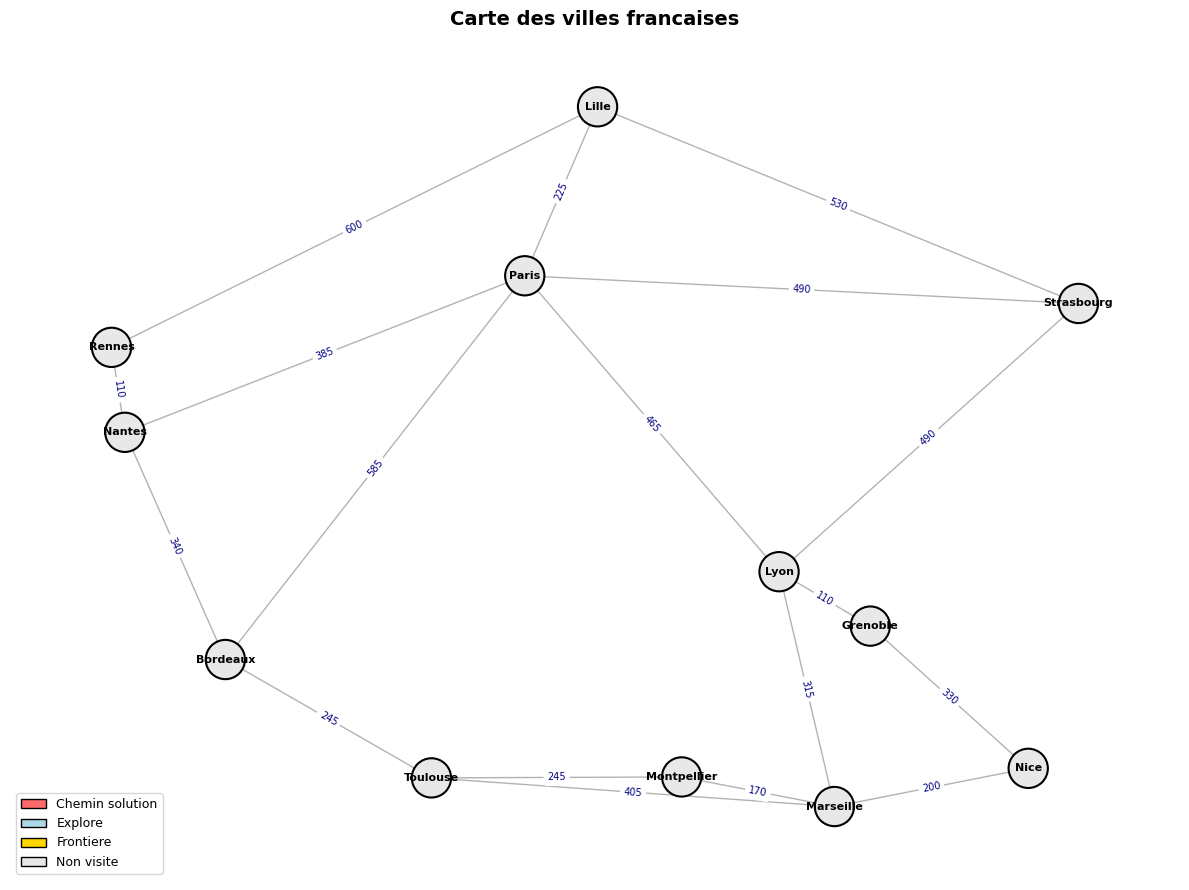

In [5]:
# --- Visualisation du graphe des villes ---

def draw_france_graph(graph, coords, path=None, explored=None,
                      frontier=None, title="Carte des villes"):
    """Dessine le graphe des villes avec un chemin optionnel."""
    G = nx.Graph()
    for city, neighbors in graph.items():
        for neighbor, dist in neighbors.items():
            G.add_edge(city, neighbor, weight=dist)

    fig, ax = plt.subplots(1, 1, figsize=(12, 9))

    # Positions basees sur les coordonnees
    pos = {city: (lon, lat) for city, (lon, lat) in coords.items()}

    # Couleurs des noeuds
    node_colors = []
    for node in G.nodes():
        if path and node in path:
            node_colors.append('#FF6B6B')  # Rouge pour le chemin
        elif explored and node in explored:
            node_colors.append('#ADD8E6')  # Bleu clair pour explores
        elif frontier and node in frontier:
            node_colors.append('#FFD700')  # Jaune pour la frontiere
        else:
            node_colors.append('#E8E8E8')  # Gris pour non visites

    # Dessiner le graphe
    nx.draw_networkx_nodes(G, pos, ax=ax, node_color=node_colors,
                           node_size=800, edgecolors='black', linewidths=1.5)
    nx.draw_networkx_labels(G, pos, ax=ax, font_size=8, font_weight='bold')

    # Aretes normales
    nx.draw_networkx_edges(G, pos, ax=ax, edge_color='gray',
                           width=1.0, alpha=0.6)

    # Distances sur les aretes
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels,
                                 ax=ax, font_size=7, font_color='navy')

    # Chemin en surbrillance
    if path and len(path) > 1:
        path_edges = [(path[i], path[i+1]) for i in range(len(path)-1)]
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, ax=ax,
                               edge_color='red', width=3.0, alpha=0.8)

    # Legende
    legend_items = [
        mpatches.Patch(facecolor='#FF6B6B', edgecolor='black', label='Chemin solution'),
        mpatches.Patch(facecolor='#ADD8E6', edgecolor='black', label='Explore'),
        mpatches.Patch(facecolor='#FFD700', edgecolor='black', label='Frontiere'),
        mpatches.Patch(facecolor='#E8E8E8', edgecolor='black', label='Non visite'),
    ]
    ax.legend(handles=legend_items, loc='lower left', fontsize=9)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.axis('off')
    plt.tight_layout()
    plt.show()

# Afficher le graphe de base
draw_france_graph(france_graph, france_coords, title="Carte des villes francaises")

### Interpretation - Graphe des villes

Le graphe represente 12 villes francaises reliees par des routes ponderes par la distance en km. Nous utiliserons ce graphe comme fil conducteur pour comparer les differents algorithmes.

**Probleme de reference** : trouver un chemin de **Bordeaux** a **Strasbourg**.

Ce probleme est interessant car :
- Plusieurs chemins existent (via Paris, via Lyon, via Toulouse-Marseille-Lyon, etc.)
- Les couts sont non uniformes (les distances varient beaucoup)
- BFS et UCS donneront des resultats differents

In [6]:
# --- Fonction utilitaire pour tracer une recherche ---

class SearchResult:
    """Resultat d'une recherche, avec statistiques."""

    def __init__(self, algorithm, solution_node=None, nodes_expanded=0,
                 nodes_generated=0, max_frontier_size=0, elapsed_ms=0,
                 explored_order=None):
        self.algorithm = algorithm
        self.solution_node = solution_node
        self.nodes_expanded = nodes_expanded
        self.nodes_generated = nodes_generated
        self.max_frontier_size = max_frontier_size
        self.elapsed_ms = elapsed_ms
        self.explored_order = explored_order or []

    @property
    def found(self):
        return self.solution_node is not None

    @property
    def path(self):
        if self.solution_node:
            return [n.state for n in self.solution_node.path()]
        return []

    @property
    def cost(self):
        if self.solution_node:
            return self.solution_node.path_cost
        return float('inf')

    def display(self):
        print(f"\n--- {self.algorithm} ---")
        if self.found:
            print(f"  Chemin     : {' -> '.join(self.path)}")
            print(f"  Cout total : {self.cost}")
            print(f"  Longueur   : {len(self.path) - 1} etapes")
        else:
            print(f"  Aucune solution trouvee.")
        print(f"  Noeuds explores  : {self.nodes_expanded}")
        print(f"  Noeuds generes   : {self.nodes_generated}")
        print(f"  Frontiere max    : {self.max_frontier_size}")
        print(f"  Temps            : {self.elapsed_ms:.2f} ms")

print("Framework de recherche pret.")

Framework de recherche pret.


## 3. Recherche en Largeur (BFS - Breadth-First Search)

BFS explore l'arbre de recherche **niveau par niveau** : tous les noeuds de profondeur $d$ sont explores avant ceux de profondeur $d+1$.

### Principe

La frontiere est geree comme une **file FIFO** (First In, First Out) :
- Les noeuds sont ajoutes a la **fin** de la file
- Le noeud a explorer est retire du **debut** de la file

### Proprietes theoriques

| Propriete | Valeur | Condition |
|-----------|--------|----------|
| Completude | Oui | Si $b$ est fini |
| Optimalite | Oui | Si les couts sont uniformes (cout = 1) |
| Complexite temporelle | $O(b^d)$ | |
| Complexite spatiale | $O(b^d)$ | Tous les noeuds de la frontiere en memoire |

In [7]:
def breadth_first_search(problem, verbose=False):
    """
    Recherche en largeur (Graph-Search).
    Frontiere = file FIFO (collections.deque).
    """
    start_time = time.perf_counter()

    node = Node(problem.initial)
    if problem.goal_test(node.state):
        elapsed = (time.perf_counter() - start_time) * 1000
        return SearchResult('BFS', node, 0, 0, 1, elapsed)

    frontier = deque([node])             # File FIFO
    frontier_states = {node.state}       # Pour recherche rapide O(1)
    explored = set()                     # Etats deja explores
    explored_order = []                  # Ordre d'exploration
    nodes_expanded = 0
    nodes_generated = 0
    max_frontier = 1

    while frontier:
        node = frontier.popleft()        # Retirer du debut (FIFO)
        frontier_states.discard(node.state)
        explored.add(node.state)
        explored_order.append(node.state)
        nodes_expanded += 1

        if verbose:
            frontier_preview = [n.state for n in list(frontier)[:5]]
            more = f"... (+{len(frontier)-5})" if len(frontier) > 5 else ""
            print(f"  Explore: {node.state:15s} | Frontiere: {frontier_preview}{more}")

        for child in node.expand(problem):
            nodes_generated += 1
            if child.state not in explored and child.state not in frontier_states:
                if problem.goal_test(child.state):
                    elapsed = (time.perf_counter() - start_time) * 1000
                    explored_order.append(child.state)
                    return SearchResult('BFS', child, nodes_expanded,
                                        nodes_generated, max_frontier,
                                        elapsed, explored_order)
                frontier.append(child)   # Ajouter a la fin (FIFO)
                frontier_states.add(child.state)
                max_frontier = max(max_frontier, len(frontier))

    elapsed = (time.perf_counter() - start_time) * 1000
    return SearchResult('BFS', None, nodes_expanded, nodes_generated,
                        max_frontier, elapsed, explored_order)

Testons BFS sur notre probleme de reference : trouver un chemin de Bordeaux a Strasbourg.

In [8]:
# --- Application de BFS au probleme Bordeaux -> Strasbourg ---

problem_bs = GraphProblem('Bordeaux', 'Strasbourg', france_graph)

print("BFS : Bordeaux -> Strasbourg")
print("=" * 60)
result_bfs = breadth_first_search(problem_bs, verbose=True)
result_bfs.display()

BFS : Bordeaux -> Strasbourg
  Explore: Bordeaux        | Frontiere: []
  Explore: Paris           | Frontiere: ['Toulouse', 'Nantes']

--- BFS ---
  Chemin     : Bordeaux -> Paris -> Strasbourg
  Cout total : 1075
  Longueur   : 2 etapes
  Noeuds explores  : 2
  Noeuds generes   : 6
  Frontiere max    : 4
  Temps            : 0.05 ms


### Interpretation - BFS sur les villes francaises

**Sortie obtenue** : BFS explore les villes par "cercles concentriques" autour de Bordeaux.

| Etape | Observation |
|-------|-------------|
| Profondeur 0 | Bordeaux (depart) |
| Profondeur 1 | Voisins directs de Bordeaux (Paris, Toulouse, Nantes) |
| Profondeur 2 | Voisins des voisins (Lyon, Lille, Strasbourg via Paris, etc.) |

**Points cles** :
1. BFS trouve le chemin avec le **minimum d'etapes** (le moins de villes intermediaires)
2. Ce n'est **pas** forcement le chemin le plus court en km, car les distances sont non uniformes
3. Le chemin via Paris est direct en nombre d'etapes, mais peut ne pas etre optimal en distance

> **Rappel** : BFS est optimal uniquement quand tous les couts d'action sont identiques.

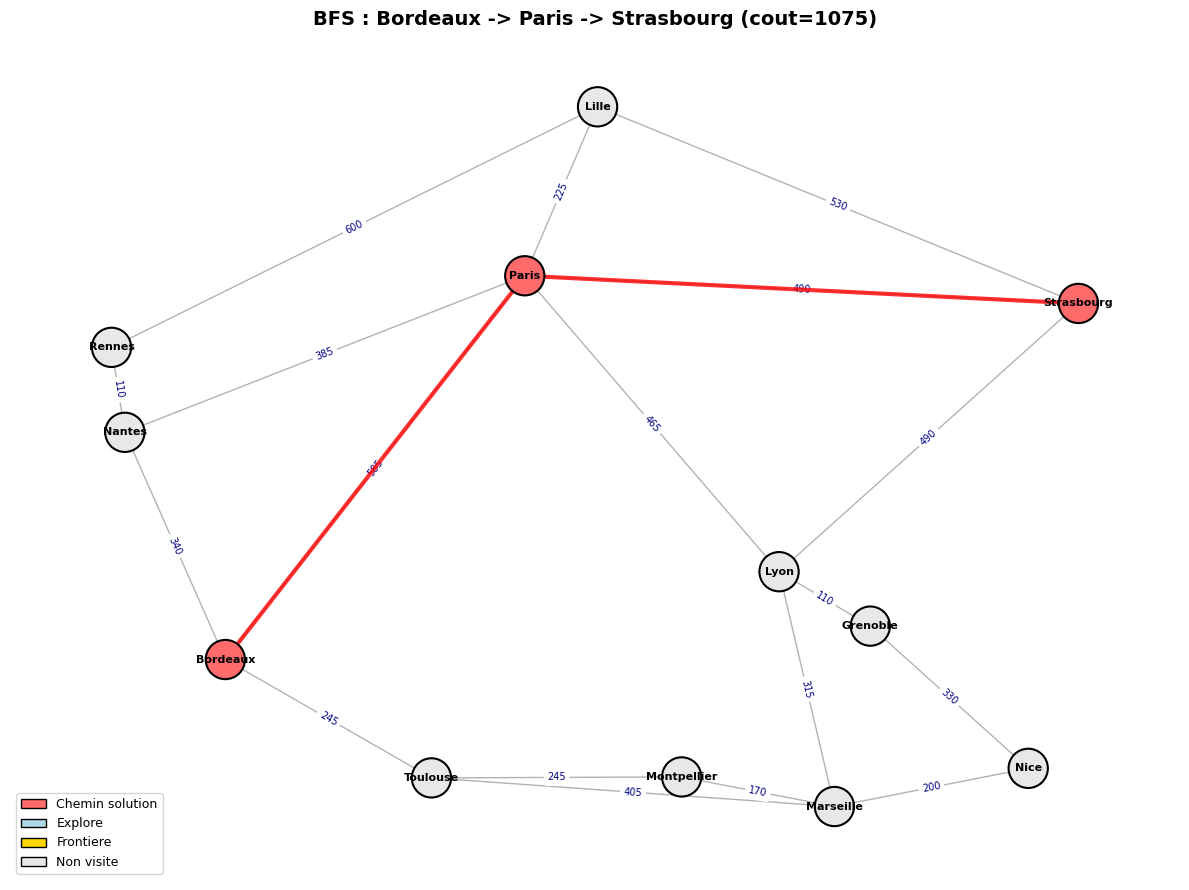

In [9]:
# Visualisation du resultat BFS
draw_france_graph(france_graph, france_coords,
                  path=result_bfs.path,
                  explored=set(result_bfs.explored_order),
                  title=f"BFS : {' -> '.join(result_bfs.path)} (cout={result_bfs.cost})")

## 4. Recherche en Profondeur (DFS - Depth-First Search)

DFS explore l'arbre de recherche en allant **le plus profondement possible** avant de revenir en arriere (backtracking).

### Principe

La frontiere est geree comme une **pile LIFO** (Last In, First Out) :
- Les noeuds sont ajoutes au **sommet** de la pile
- Le noeud a explorer est retire du **sommet** de la pile

### Proprietes theoriques

| Propriete | Valeur | Condition |
|-----------|--------|----------|
| Completude | Non | Peut boucler dans les espaces infinis (Tree-Search) |
| Completude | Oui | Graph-Search dans les espaces finis |
| Optimalite | Non | Peut trouver une solution sous-optimale |
| Complexite temporelle | $O(b^m)$ | $m$ = profondeur maximale |
| Complexite spatiale | $O(bm)$ | Seulement le chemin courant + freres |

In [10]:
def depth_first_search(problem, verbose=False):
    """
    Recherche en profondeur (Graph-Search).
    Frontiere = pile LIFO (liste Python).
    """
    start_time = time.perf_counter()

    node = Node(problem.initial)
    if problem.goal_test(node.state):
        elapsed = (time.perf_counter() - start_time) * 1000
        return SearchResult('DFS', node, 0, 0, 1, elapsed)

    frontier = [node]                    # Pile LIFO
    explored = set()                     # Etats deja explores
    explored_order = []                  # Ordre d'exploration
    nodes_expanded = 0
    nodes_generated = 0
    max_frontier = 1

    while frontier:
        node = frontier.pop()            # Retirer du sommet (LIFO)

        if problem.goal_test(node.state):
            elapsed = (time.perf_counter() - start_time) * 1000
            explored_order.append(node.state)
            return SearchResult('DFS', node, nodes_expanded,
                                nodes_generated, max_frontier,
                                elapsed, explored_order)

        if node.state in explored:
            continue

        explored.add(node.state)
        explored_order.append(node.state)
        nodes_expanded += 1

        if verbose:
            frontier_preview = [n.state for n in frontier[-5:]]
            print(f"  Explore: {node.state:15s} (prof={node.depth}) | "
                  f"Pile: {frontier_preview}")

        for child in node.expand(problem):
            nodes_generated += 1
            if child.state not in explored:
                frontier.append(child)   # Empiler (LIFO)
                max_frontier = max(max_frontier, len(frontier))

    elapsed = (time.perf_counter() - start_time) * 1000
    return SearchResult('DFS', None, nodes_expanded, nodes_generated,
                        max_frontier, elapsed, explored_order)

Appliquons DFS au meme probleme Bordeaux-Strasbourg pour comparer avec BFS.

In [11]:
# --- Application de DFS au probleme Bordeaux -> Strasbourg ---

print("DFS : Bordeaux -> Strasbourg")
print("=" * 60)
result_dfs = depth_first_search(problem_bs, verbose=True)
result_dfs.display()

DFS : Bordeaux -> Strasbourg
  Explore: Bordeaux        (prof=0) | Pile: []
  Explore: Nantes          (prof=1) | Pile: ['Paris', 'Toulouse']
  Explore: Rennes          (prof=2) | Pile: ['Paris', 'Toulouse', 'Paris']
  Explore: Lille           (prof=3) | Pile: ['Paris', 'Toulouse', 'Paris']

--- DFS ---
  Chemin     : Bordeaux -> Nantes -> Rennes -> Lille -> Strasbourg
  Cout total : 1580
  Longueur   : 4 etapes
  Noeuds explores  : 4
  Noeuds generes   : 11
  Frontiere max    : 5
  Temps            : 0.08 ms


### Interpretation - DFS vs BFS

**Sortie obtenue** : DFS suit un chemin en profondeur avant de considerer les alternatives.

| Aspect | BFS | DFS |
|--------|-----|-----|
| Strategie | Explore par niveaux | Explore une branche a fond |
| Chemin trouve | Minimum d'etapes | Pas forcement le plus court |
| Memoire | Stocke tout le niveau courant | Stocke seulement la branche courante |

**Observations** :
1. DFS peut trouver un chemin **plus long** que BFS (en nombre d'etapes)
2. L'**ordre d'exploration** est tres different : DFS "fonce" dans une direction
3. La **frontiere maximale** de DFS est generalement plus petite que celle de BFS

> **Avantage de DFS** : memoire lineaire en $O(bm)$ contre $O(b^d)$ pour BFS. Pour un arbre de profondeur 20 et de branchement 10, DFS utilise ~200 noeuds vs ~$10^{20}$ pour BFS.

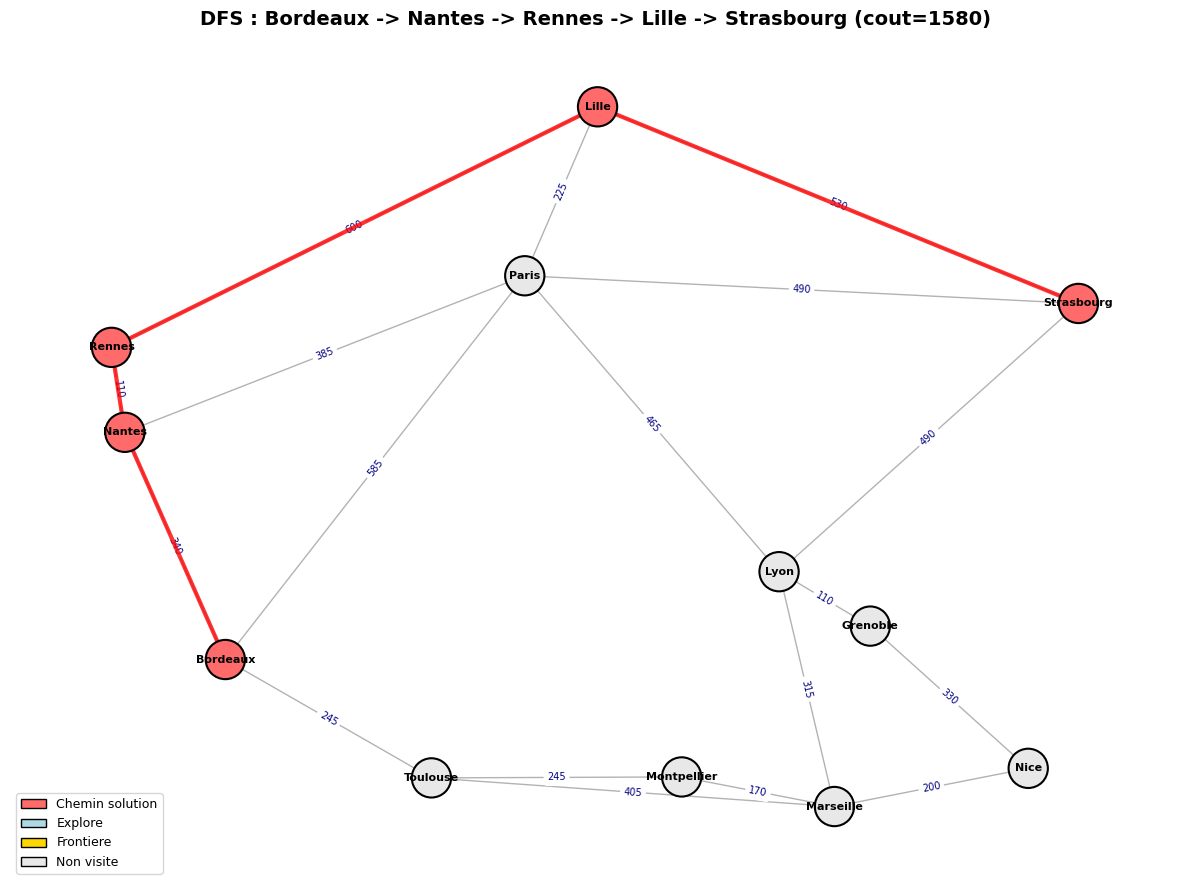

In [12]:
# Visualisation du resultat DFS
draw_france_graph(france_graph, france_coords,
                  path=result_dfs.path,
                  explored=set(result_dfs.explored_order),
                  title=f"DFS : {' -> '.join(result_dfs.path)} (cout={result_dfs.cost})")

### Illustration : Ordre d'expansion BFS vs DFS sur un arbre

Pour mieux comprendre la difference, visualisons l'ordre d'expansion sur un petit arbre binaire.

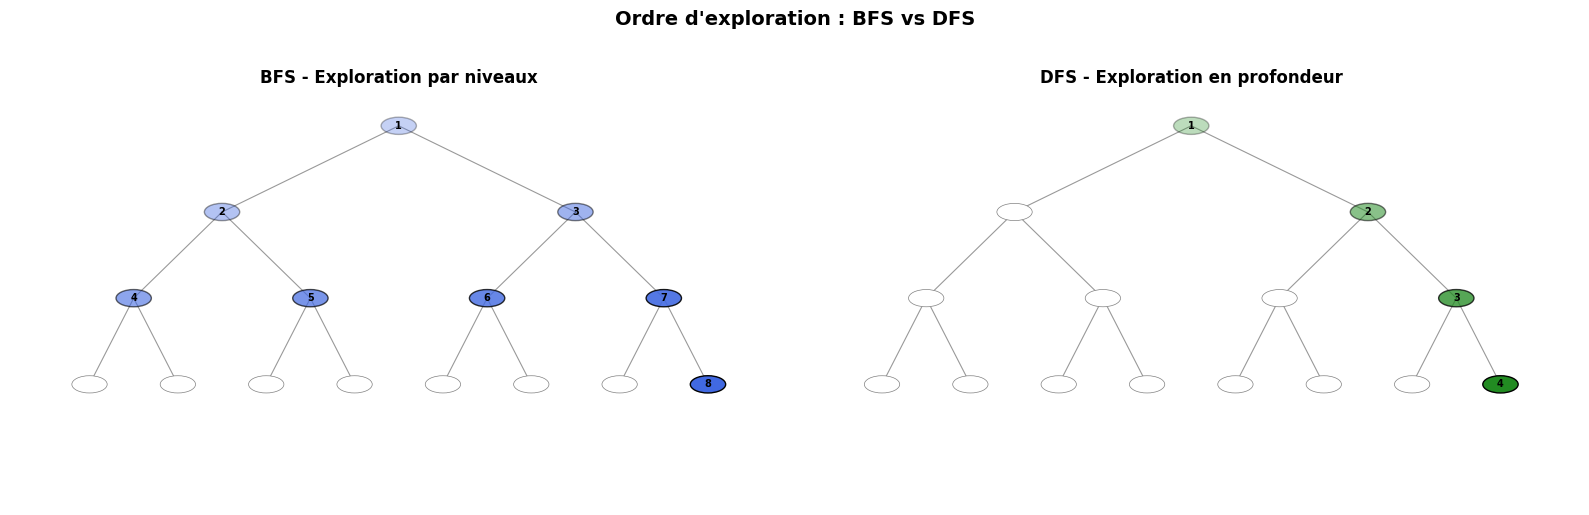

BFS : 8 noeuds explores, chemin de longueur 3
DFS : 4 noeuds explores, chemin de longueur 3


In [13]:
# --- Comparaison visuelle BFS vs DFS sur un arbre binaire ---

def build_binary_tree_graph(depth=3):
    """Construit un graphe representant un arbre binaire."""
    graph = {}
    goal_node = None
    for d in range(depth):
        for i in range(2**d):
            node = f"N{d}_{i}"
            graph[node] = {}
            # Fils gauche et droit
            if d < depth - 1:
                left = f"N{d+1}_{2*i}"
                right = f"N{d+1}_{2*i+1}"
                graph[node][left] = 1
                graph[node][right] = 1
            else:
                # Le but est la derniere feuille
                goal_node = node
    return graph, goal_node

tree_graph, tree_goal = build_binary_tree_graph(depth=4)
tree_problem = GraphProblem('N0_0', tree_goal, tree_graph)

# Executer BFS et DFS
bfs_tree = breadth_first_search(tree_problem)
dfs_tree = depth_first_search(tree_problem)

# Afficher les ordres d'exploration
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

for ax, result, color, title in [
    (axes[0], bfs_tree, '#4169E1', 'BFS - Exploration par niveaux'),
    (axes[1], dfs_tree, '#228B22', 'DFS - Exploration en profondeur'),
]:
    order = result.explored_order
    # Creer les positions pour l'arbre
    positions = {}
    for name in tree_graph:
        parts = name.split('_')
        d = int(parts[0][1:])
        i = int(parts[1])
        x = (i + 0.5) / (2**d)
        y = 1.0 - d * 0.25
        positions[name] = (x, y)

    # Dessiner les aretes
    for node_name, neighbors in tree_graph.items():
        for neighbor in neighbors:
            if node_name in positions and neighbor in positions:
                x1, y1 = positions[node_name]
                x2, y2 = positions[neighbor]
                ax.plot([x1, x2], [y1, y2], 'k-', linewidth=0.8, alpha=0.4)

    # Dessiner les noeuds avec le numero d'exploration
    for idx, node_name in enumerate(order):
        if node_name in positions:
            x, y = positions[node_name]
            circle = plt.Circle((x, y), 0.025, color=color,
                                ec='black', linewidth=1, zorder=5,
                                alpha=0.3 + 0.7 * (idx / max(len(order)-1, 1)))
            ax.add_patch(circle)
            ax.text(x, y, str(idx+1), ha='center', va='center',
                    fontsize=7, fontweight='bold', zorder=6)

    # Noeuds non explores
    for node_name in tree_graph:
        if node_name not in order and node_name in positions:
            x, y = positions[node_name]
            circle = plt.Circle((x, y), 0.025, color='white',
                                ec='gray', linewidth=0.5, zorder=5)
            ax.add_patch(circle)

    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.1, 1.1)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.axis('off')

plt.suptitle("Ordre d'exploration : BFS vs DFS", fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"BFS : {len(bfs_tree.explored_order)} noeuds explores, "
      f"chemin de longueur {len(bfs_tree.path)-1}")
print(f"DFS : {len(dfs_tree.explored_order)} noeuds explores, "
      f"chemin de longueur {len(dfs_tree.path)-1}")

### Interpretation - Ordres d'exploration

Les numeros dans les noeuds indiquent l'**ordre d'exploration** :

| Algorithme | Ordre | Comportement |
|------------|-------|-------------|
| BFS | 1, 2, 3, 4, 5, 6, 7, ... | Balaye chaque niveau completement avant le suivant |
| DFS | 1, 2, 4, 8, ... puis backtrack | Descend au plus profond, puis remonte |

**Points cles** :
1. BFS garantit de trouver le noeud but **le plus proche** (profondeur minimale)
2. DFS peut trouver le but **plus vite** s'il est du "bon cote" de l'arbre
3. DFS peut aussi explorer **beaucoup plus** de noeuds si le but est du "mauvais cote"

## 5. Recherche a Cout Uniforme (UCS - Uniform Cost Search)

UCS generalise BFS aux graphes avec des **couts non uniformes**. Au lieu d'explorer par profondeur, il explore par **cout croissant**.

### Principe

La frontiere est geree comme une **file de priorite** (min-heap) ordonnee par le cout du chemin $g(n)$ :
- Le noeud de **cout minimal** est explore en premier
- Equivalent a l'algorithme de Dijkstra pour un objectif unique

### Proprietes theoriques

| Propriete | Valeur | Condition |
|-----------|--------|----------|
| Completude | Oui | Si $\epsilon > 0$ (couts strictement positifs) |
| Optimalite | Oui | Toujours (tant que $\epsilon > 0$) |
| Complexite temporelle | $O(b^{1+\lfloor C^*/\epsilon \rfloor})$ | |
| Complexite spatiale | $O(b^{1+\lfloor C^*/\epsilon \rfloor})$ | |

In [14]:
def uniform_cost_search(problem, verbose=False):
    """
    Recherche a cout uniforme (Graph-Search).
    Frontiere = file de priorite (heapq), ordonnee par path_cost.
    """
    start_time = time.perf_counter()

    node = Node(problem.initial)
    frontier = []                        # Min-heap
    counter = 0                          # Tie-breaker pour heapq
    heapq.heappush(frontier, (node.path_cost, counter, node))
    counter += 1
    frontier_map = {node.state: node.path_cost}  # etat -> meilleur cout connu
    explored = set()
    explored_order = []
    nodes_expanded = 0
    nodes_generated = 0
    max_frontier = 1

    while frontier:
        cost, _, node = heapq.heappop(frontier)

        if problem.goal_test(node.state):
            elapsed = (time.perf_counter() - start_time) * 1000
            explored_order.append(node.state)
            return SearchResult('UCS', node, nodes_expanded,
                                nodes_generated, max_frontier,
                                elapsed, explored_order)

        if node.state in explored:
            continue

        explored.add(node.state)
        explored_order.append(node.state)
        nodes_expanded += 1

        if verbose:
            print(f"  Explore: {node.state:15s} (cout={node.path_cost:6.0f}) | "
                  f"Frontiere: {len(frontier)} noeuds")

        for child in node.expand(problem):
            nodes_generated += 1
            if child.state not in explored:
                old_cost = frontier_map.get(child.state, float('inf'))
                if child.path_cost < old_cost:
                    heapq.heappush(frontier, (child.path_cost, counter, child))
                    counter += 1
                    frontier_map[child.state] = child.path_cost
                    max_frontier = max(max_frontier, len(frontier))

    elapsed = (time.perf_counter() - start_time) * 1000
    return SearchResult('UCS', None, nodes_expanded, nodes_generated,
                        max_frontier, elapsed, explored_order)

Appliquons UCS a notre probleme de reference et comparons avec les resultats de BFS.

In [15]:
# --- Application de UCS au probleme Bordeaux -> Strasbourg ---

print("UCS : Bordeaux -> Strasbourg")
print("=" * 60)
result_ucs = uniform_cost_search(problem_bs, verbose=True)
result_ucs.display()

UCS : Bordeaux -> Strasbourg
  Explore: Bordeaux        (cout=     0) | Frontiere: 0 noeuds
  Explore: Toulouse        (cout=   245) | Frontiere: 2 noeuds
  Explore: Nantes          (cout=   340) | Frontiere: 3 noeuds
  Explore: Rennes          (cout=   450) | Frontiere: 3 noeuds
  Explore: Montpellier     (cout=   490) | Frontiere: 3 noeuds
  Explore: Paris           (cout=   585) | Frontiere: 2 noeuds
  Explore: Marseille       (cout=   650) | Frontiere: 4 noeuds
  Explore: Lille           (cout=   810) | Frontiere: 5 noeuds
  Explore: Nice            (cout=   850) | Frontiere: 4 noeuds
  Explore: Lyon            (cout=   965) | Frontiere: 4 noeuds

--- UCS ---
  Chemin     : Bordeaux -> Paris -> Strasbourg
  Cout total : 1075
  Longueur   : 2 etapes
  Noeuds explores  : 10
  Noeuds generes   : 31
  Frontiere max    : 6
  Temps            : 0.28 ms


### Interpretation - UCS trouve le chemin optimal

**Sortie obtenue** : UCS explore les noeuds par **cout croissant**, garantissant l'optimalite.

| Aspect | BFS | UCS |
|--------|-----|-----|
| Critere d'expansion | Profondeur minimale | Cout minimal |
| Optimalite | Uniquement si couts uniformes | Toujours |
| Frontiere | File FIFO | File de priorite |

**Observations** :
1. UCS peut explorer plus de noeuds que BFS (il suit les routes les moins cheres, pas les plus directes)
2. Le chemin trouve est garanti **optimal en distance** (km)
3. L'ordre d'exploration depend des couts : une ville eloignee en etapes peut etre exploree tot si elle est accessible par une route courte

> **Point important** : Quand les couts sont identiques (tous egaux a 1), UCS se comporte exactement comme BFS.

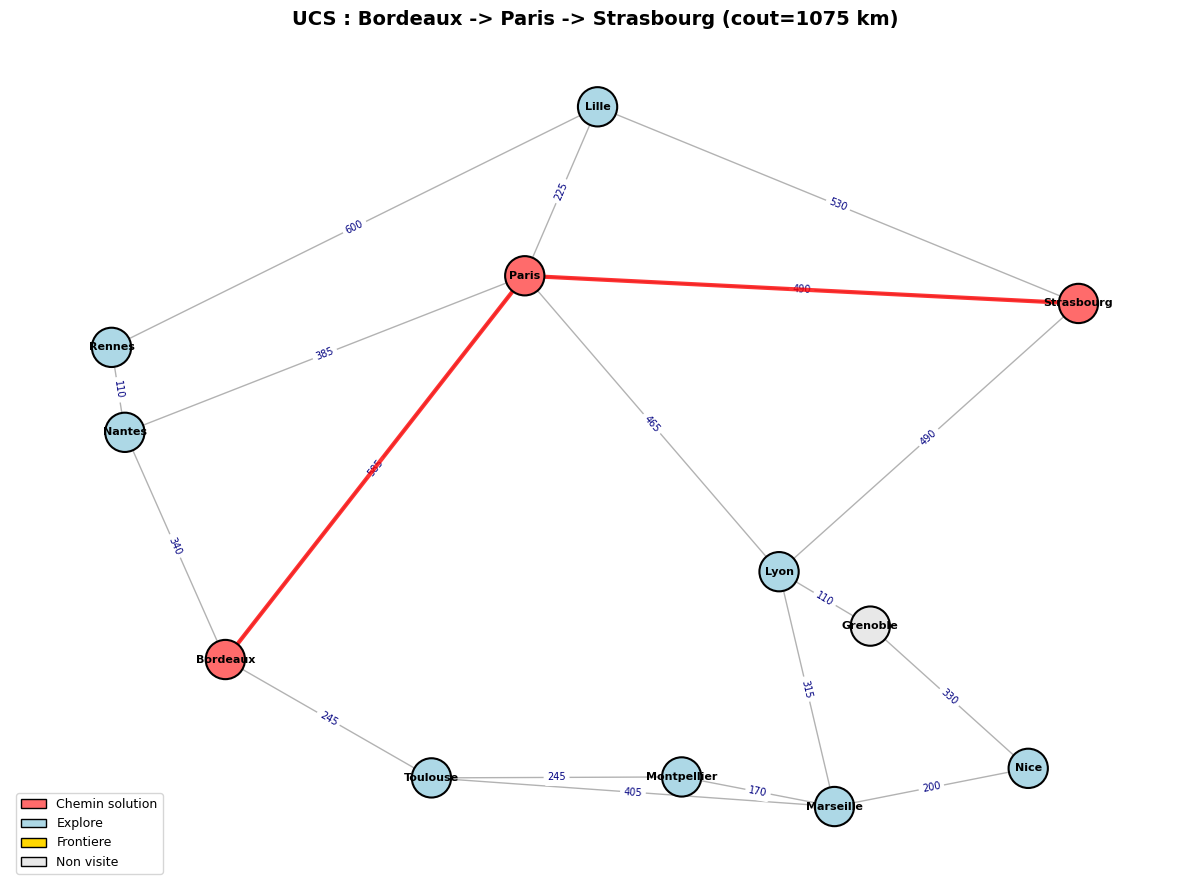

In [16]:
# Visualisation du resultat UCS
draw_france_graph(france_graph, france_coords,
                  path=result_ucs.path,
                  explored=set(result_ucs.explored_order),
                  title=f"UCS : {' -> '.join(result_ucs.path)} (cout={result_ucs.cost} km)")

## 6. Recherche en Profondeur Iteree (IDDFS - Iterative Deepening DFS)

IDDFS combine les avantages de BFS (completude, optimalite avec couts uniformes) et de DFS (faible consommation memoire).

### Principe

IDDFS execute une serie de **recherches en profondeur limitee** (Depth-Limited Search) avec des limites croissantes : 0, 1, 2, 3, ...

A chaque iteration :
1. DFS avec limite de profondeur $\ell$
2. Si solution trouvee : retourner
3. Sinon : incrementer $\ell$ et recommencer depuis la racine

### Proprietes theoriques

| Propriete | Valeur | Condition |
|-----------|--------|----------|
| Completude | Oui | Si $b$ est fini |
| Optimalite | Oui | Si les couts sont uniformes |
| Complexite temporelle | $O(b^d)$ | Meme ordre que BFS |
| Complexite spatiale | $O(bd)$ | Lineaire (meme que DFS) |

### L'overhead est negligeable

On pourrait penser que re-explorer les niveaux superieurs est couteux. En realite, le nombre total de noeuds generes est :

$$N(IDDFS) = (d)b + (d-1)b^2 + ... + (1)b^d$$

Pour $b=10, d=5$ : $N(IDDFS) = 123\,456$ vs $N(BFS) = 111\,111$. L'overhead n'est que d'environ 11%.

In [17]:
def depth_limited_search(problem, limit, verbose=False):
    """
    Recherche en profondeur limitee.
    Retourne (result_node, cutoff_occurred)
    """
    nodes_expanded = 0
    nodes_generated = 0
    explored_order = []

    def recursive_dls(node, limit_remaining):
        nonlocal nodes_expanded, nodes_generated

        if problem.goal_test(node.state):
            explored_order.append(node.state)
            return node, False  # Trouve, pas de coupure

        if limit_remaining == 0:
            return None, True   # Coupure : limite atteinte

        explored_order.append(node.state)
        nodes_expanded += 1
        cutoff_occurred = False

        for child in node.expand(problem):
            nodes_generated += 1
            result, cutoff = recursive_dls(child, limit_remaining - 1)
            if cutoff:
                cutoff_occurred = True
            elif result is not None:
                return result, False

        return None, cutoff_occurred

    root = Node(problem.initial)
    result, cutoff = recursive_dls(root, limit)
    return result, cutoff, nodes_expanded, nodes_generated, explored_order


def iterative_deepening_search(problem, max_depth=50, verbose=False):
    """
    Recherche en profondeur iteree (IDDFS).
    Enchaine des DFS limitees avec des profondeurs croissantes.
    """
    start_time = time.perf_counter()
    total_expanded = 0
    total_generated = 0
    all_explored = []

    for depth_limit in range(max_depth + 1):
        result, cutoff, expanded, generated, explored = \
            depth_limited_search(problem, depth_limit)

        total_expanded += expanded
        total_generated += generated

        if verbose:
            status = "Solution!" if result else ("Coupure" if cutoff else "Echec")
            print(f"  Limite={depth_limit:2d} | Explores={expanded:4d} | "
                  f"Generes={generated:4d} | {status}")

        if result is not None:
            elapsed = (time.perf_counter() - start_time) * 1000
            # Fusionner les noeuds explores de la derniere iteration
            all_explored = explored
            return SearchResult('IDDFS', result, total_expanded,
                                total_generated, depth_limit,
                                elapsed, all_explored)

        if not cutoff:
            break  # Espace entier explore, pas de solution

    elapsed = (time.perf_counter() - start_time) * 1000
    return SearchResult('IDDFS', None, total_expanded, total_generated,
                        0, elapsed, all_explored)

Appliquons maintenant IDDFS a notre probleme de reference et observons le comportement iteratif.

In [18]:
# --- Application de IDDFS au probleme Bordeaux -> Strasbourg ---

print("IDDFS : Bordeaux -> Strasbourg")
print("=" * 60)
result_iddfs = iterative_deepening_search(problem_bs, verbose=True)
result_iddfs.display()

IDDFS : Bordeaux -> Strasbourg
  Limite= 0 | Explores=   0 | Generes=   0 | Coupure
  Limite= 1 | Explores=   1 | Generes=   3 | Coupure
  Limite= 2 | Explores=   2 | Generes=   4 | Solution!

--- IDDFS ---
  Chemin     : Bordeaux -> Paris -> Strasbourg
  Cout total : 1075
  Longueur   : 2 etapes
  Noeuds explores  : 3
  Noeuds generes   : 7
  Frontiere max    : 2
  Temps            : 0.07 ms


### Interpretation - IDDFS et l'overhead de re-exploration

**Sortie obtenue** : IDDFS teste successivement les limites de profondeur 0, 1, 2, ... jusqu'a trouver une solution.

| Iteration | Limite | Noeuds explores | Resultat |
|-----------|--------|-----------------|----------|
| 1 | 0 | 0 | Coupure (profondeur insuffisante) |
| 2 | 1 | quelques | Coupure |
| ... | ... | ... | ... |
| Derniere | $d$ | tous les niveaux $\leq d$ | Solution trouvee |

**Points cles** :
1. IDDFS trouve le **meme chemin** que BFS (meme profondeur minimale)
2. L'overhead de re-exploration est **modeste** : les niveaux superieurs contiennent peu de noeuds
3. La memoire utilisee est **lineaire** en $O(bd)$, pas exponentielle comme BFS
4. C'est l'algorithme recommande quand on ne connait pas la profondeur de la solution

> **Recommandation AIMA** : IDDFS est generalement la methode de recherche non informee preferee quand l'espace de recherche est grand et la profondeur de la solution inconnue.

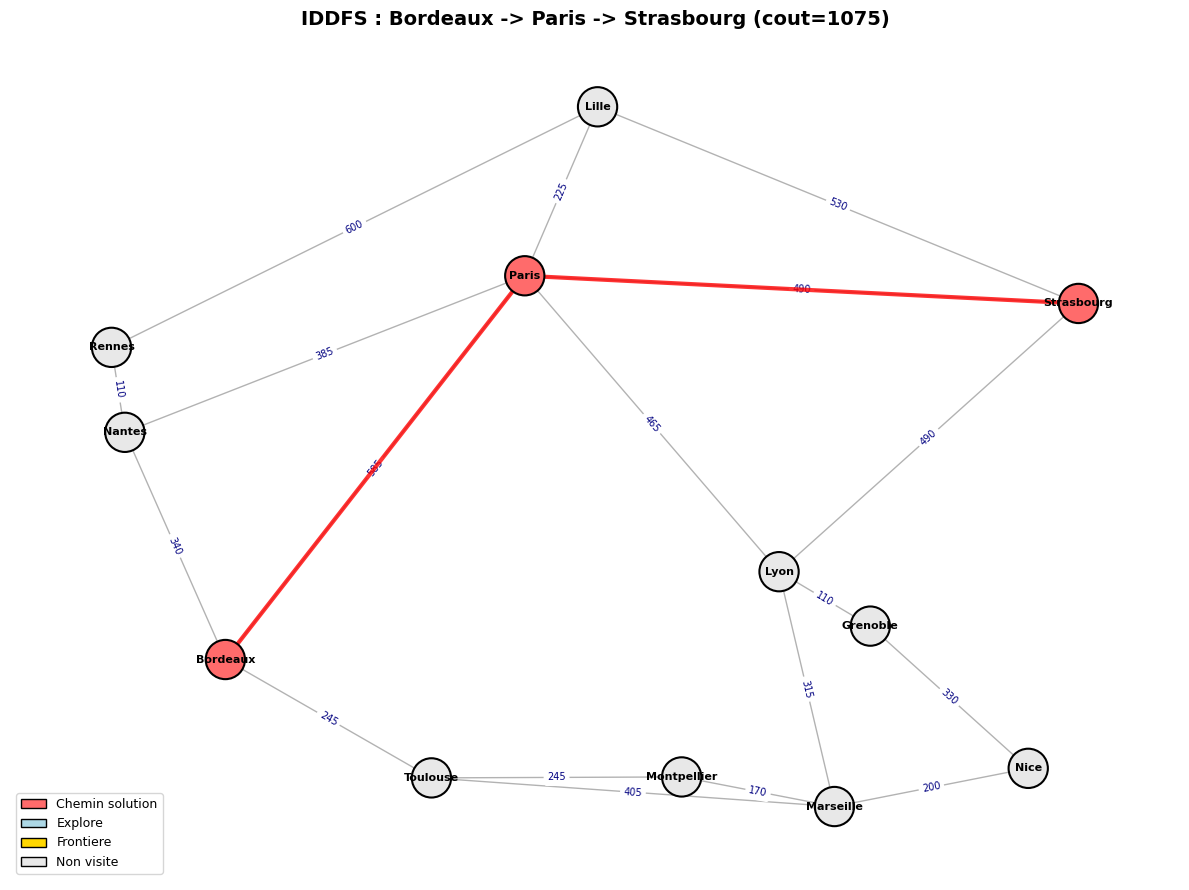

In [19]:
# Visualisation du resultat IDDFS
draw_france_graph(france_graph, france_coords,
                  path=result_iddfs.path,
                  explored=set(result_iddfs.explored_order),
                  title=f"IDDFS : {' -> '.join(result_iddfs.path)} (cout={result_iddfs.cost})")

### Analyse de l'overhead de IDDFS

Calculons l'overhead theorique de IDDFS par rapport a BFS sur un arbre regulier.

In [20]:
# --- Analyse de l'overhead de IDDFS ---

def compute_overhead(b, d):
    """Calcule le ratio noeuds generes IDDFS / BFS pour un arbre regulier."""
    # BFS genere b + b^2 + ... + b^d = b*(b^d - 1)/(b-1)
    bfs_nodes = sum(b**i for i in range(1, d+1))

    # IDDFS genere d*b + (d-1)*b^2 + ... + 1*b^d
    iddfs_nodes = sum((d - i + 1) * b**i for i in range(1, d+1))

    return bfs_nodes, iddfs_nodes, iddfs_nodes / bfs_nodes

print("Overhead de IDDFS par rapport a BFS")
print("=" * 60)
print(f"{'b':>3} {'d':>3} {'BFS noeuds':>15} {'IDDFS noeuds':>15} {'Ratio':>10}")
print("-" * 60)

for b in [2, 5, 10]:
    for d in [3, 5, 10]:
        bfs_n, iddfs_n, ratio = compute_overhead(b, d)
        print(f"{b:>3} {d:>3} {bfs_n:>15,} {iddfs_n:>15,} {ratio:>10.3f}")

Overhead de IDDFS par rapport a BFS
  b   d      BFS noeuds    IDDFS noeuds      Ratio
------------------------------------------------------------
  2   3              14              22      1.571
  2   5              62             114      1.839
  2  10           2,046           4,072      1.990
  5   3             155             190      1.226
  5   5           3,905           4,875      1.248
  5  10      12,207,030      15,258,775      1.250
 10   3           1,110           1,230      1.108
 10   5         111,110         123,450      1.111
 10  10  11,111,111,110  12,345,679,000      1.111


### Interpretation - Overhead de IDDFS

**Sortie obtenue** : le tableau montre que l'overhead de IDDFS **diminue** quand le facteur de branchement $b$ augmente.

| Branchement $b$ | Overhead approximatif |
|-----------------|----------------------|
| $b = 2$ | ~2x plus de noeuds |
| $b = 5$ | ~1.25x plus de noeuds |
| $b = 10$ | ~1.11x plus de noeuds |

**Explication** : quand $b$ est grand, le dernier niveau contient $b^d$ noeuds, ce qui domine largement les niveaux precedents. Les re-explorations des niveaux superieurs deviennent negligeables.

> **Conclusion** : pour $b \geq 5$ (tres courant en pratique), l'overhead est inferieur a 25%. Le gain en memoire ($O(bd)$ vs $O(b^d)$) justifie largement ce surcout.

## 7. Comparaison des algorithmes

Comparons les quatre algorithmes sur le meme probleme pour observer leurs differences en pratique.

In [21]:
# --- Comparaison complete sur plusieurs problemes ---

test_cases = [
    ('Bordeaux', 'Strasbourg'),
    ('Rennes', 'Nice'),
    ('Lille', 'Toulouse'),
    ('Nantes', 'Marseille'),
]

all_results = []

print("Comparaison des algorithmes sur plusieurs problemes")
print("=" * 80)

for start, goal in test_cases:
    problem = GraphProblem(start, goal, france_graph)

    results = {
        'BFS': breadth_first_search(problem),
        'DFS': depth_first_search(problem),
        'UCS': uniform_cost_search(problem),
        'IDDFS': iterative_deepening_search(problem),
    }

    print(f"\n{start} -> {goal}")
    print("-" * 80)
    print(f"{'Algo':<8} {'Chemin':<40} {'Cout':>8} {'Explores':>10} {'Generes':>10}")
    print("-" * 80)

    for name, result in results.items():
        path_str = ' -> '.join(result.path) if result.found else 'NON TROUVE'
        if len(path_str) > 38:
            path_str = path_str[:35] + '...'
        print(f"{name:<8} {path_str:<40} {result.cost:>8.0f} "
              f"{result.nodes_expanded:>10} {result.nodes_generated:>10}")

    all_results.append((start, goal, results))

Comparaison des algorithmes sur plusieurs problemes

Bordeaux -> Strasbourg
--------------------------------------------------------------------------------
Algo     Chemin                                       Cout   Explores    Generes
--------------------------------------------------------------------------------
BFS      Bordeaux -> Paris -> Strasbourg              1075          2          6
DFS      Bordeaux -> Nantes -> Rennes -> Lil...       1580          4         11
UCS      Bordeaux -> Paris -> Strasbourg              1075         10         31
IDDFS    Bordeaux -> Paris -> Strasbourg              1075          3          7

Rennes -> Nice
--------------------------------------------------------------------------------
Algo     Chemin                                       Cout   Explores    Generes
--------------------------------------------------------------------------------
BFS      Rennes -> Nantes -> Paris -> Lyon -...       1475          9         29
DFS      Rennes -

### Interpretation - Comparaison experimentale

**Observations** :

| Algorithme | Trouve le chemin... | Cout du chemin | Memoire |
|------------|--------------------|----|--------|
| **BFS** | Le moins profond (min d'etapes) | Pas forcement minimal en distance | Elevee |
| **DFS** | Le premier en profondeur | Souvent sous-optimal | Faible |
| **UCS** | De cout minimal (distance minimale) | **Optimal** | Elevee |
| **IDDFS** | Le moins profond (comme BFS) | Optimal si couts uniformes | **Faible** |

**Points cles** :
1. **UCS** donne toujours le **meilleur cout** quand les distances varient
2. **BFS** et **IDDFS** donnent le meme chemin (meme profondeur), mais des couts differents de UCS
3. **DFS** peut trouver des chemins tres longs et couteux
4. **IDDFS** explore plus de noeuds au total (overhead), mais utilise peu de memoire

In [22]:
# --- Tableau recapitulatif et graphique ---

# Tableau recapitulatif theorique
print("\nTableau recapitulatif des proprietes")
print("=" * 85)
print(f"{'Algorithme':<12} {'Complet?':<12} {'Optimal?':<15} "
      f"{'Temps':<18} {'Espace':<15} {'Frontiere':<10}")
print("-" * 85)
rows = [
    ('BFS',   'Oui',  'Oui*',  'O(b^d)',        'O(b^d)',        'FIFO'),
    ('DFS',   'Non',  'Non',   'O(b^m)',        'O(bm)',         'LIFO'),
    ('UCS',   'Oui',  'Oui',   'O(b^(1+C*/e))', 'O(b^(1+C*/e))', 'Priorite'),
    ('IDDFS', 'Oui',  'Oui*',  'O(b^d)',        'O(bd)',         'LIFO'),
]
for row in rows:
    print(f"{row[0]:<12} {row[1]:<12} {row[2]:<15} {row[3]:<18} {row[4]:<15} {row[5]:<10}")

print("\n* Optimal uniquement si tous les couts d'action sont identiques.")


Tableau recapitulatif des proprietes
Algorithme   Complet?     Optimal?        Temps              Espace          Frontiere 
-------------------------------------------------------------------------------------
BFS          Oui          Oui*            O(b^d)             O(b^d)          FIFO      
DFS          Non          Non             O(b^m)             O(bm)           LIFO      
UCS          Oui          Oui             O(b^(1+C*/e))      O(b^(1+C*/e))   Priorite  
IDDFS        Oui          Oui*            O(b^d)             O(bd)           LIFO      

* Optimal uniquement si tous les couts d'action sont identiques.


Visualisons maintenant ces resultats sous forme de graphiques en barres pour mieux comparer les performances.

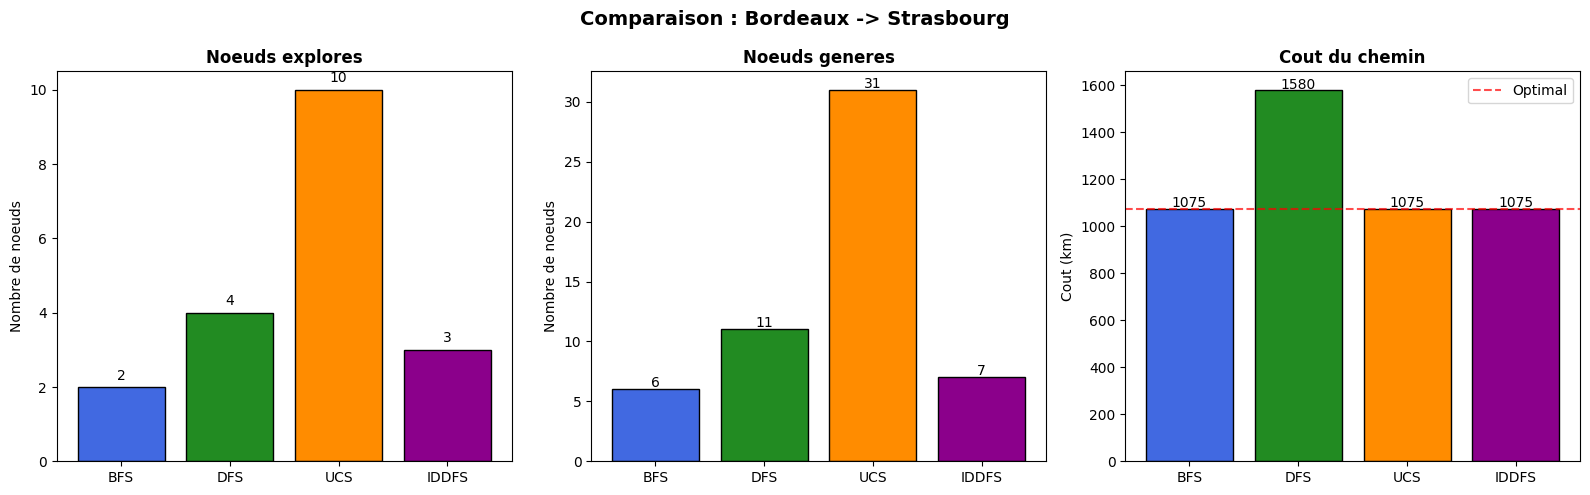

In [23]:
# --- Graphique comparatif ---

# Utiliser le premier probleme (Bordeaux -> Strasbourg) pour le graphique
_, _, results_bs = all_results[0]

algos = ['BFS', 'DFS', 'UCS', 'IDDFS']
expanded = [results_bs[a].nodes_expanded for a in algos]
generated = [results_bs[a].nodes_generated for a in algos]
costs = [results_bs[a].cost for a in algos]

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Noeuds explores
colors = ['#4169E1', '#228B22', '#FF8C00', '#8B008B']
axes[0].bar(algos, expanded, color=colors, edgecolor='black')
axes[0].set_ylabel('Nombre de noeuds')
axes[0].set_title('Noeuds explores', fontweight='bold')
for i, v in enumerate(expanded):
    axes[0].text(i, v + 0.2, str(v), ha='center', fontsize=10)

# Noeuds generes
axes[1].bar(algos, generated, color=colors, edgecolor='black')
axes[1].set_ylabel('Nombre de noeuds')
axes[1].set_title('Noeuds generes', fontweight='bold')
for i, v in enumerate(generated):
    axes[1].text(i, v + 0.2, str(v), ha='center', fontsize=10)

# Cout de la solution
axes[2].bar(algos, costs, color=colors, edgecolor='black')
axes[2].set_ylabel('Cout (km)')
axes[2].set_title('Cout du chemin', fontweight='bold')
for i, v in enumerate(costs):
    axes[2].text(i, v + 5, f"{v:.0f}", ha='center', fontsize=10)

# Marquer le cout optimal
optimal_cost = min(costs)
axes[2].axhline(y=optimal_cost, color='red', linestyle='--', alpha=0.7, label='Optimal')
axes[2].legend()

plt.suptitle('Comparaison : Bordeaux -> Strasbourg', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Interpretation - Graphiques comparatifs

Les trois graphiques montrent les compromis entre les algorithmes :

| Critere | Meilleur algorithme | Explication |
|---------|--------------------|--------------|
| Noeuds explores | DFS ou BFS (selon le graphe) | DFS peut trouver vite si le but est "en profondeur" |
| Cout du chemin | UCS | Seul algorithme garantissant l'optimalite avec couts variables |
| Memoire | DFS / IDDFS | Complexite spatiale lineaire vs exponentielle |

**Synthese** :
- Si les couts sont **uniformes** et la memoire est **limitee** : utiliser **IDDFS**
- Si les couts sont **variables** : utiliser **UCS**
- Si on a **assez de memoire** et les couts sont uniformes : **BFS** est le plus simple
- **DFS** est rarement le meilleur choix seul, mais il est utile comme sous-routine (dans IDDFS)

## 8. Exercices

### Exercice 1 : Trace manuelle de BFS

Considerez le graphe suivant (couts uniformes) :

```
        A
       / \
      B   C
     / \   \
    D   E   F
   /       / \
  G       H   I (but)
```

**Question** : Tracez l'execution de BFS depuis A vers I. A chaque etape, indiquez le contenu de la frontiere et l'ensemble des etats explores.

**Indice** : Utilisez le code ci-dessous pour verifier votre reponse.

In [24]:
# --- Exercice 1 : Trace BFS sur un petit graphe ---

exercise_graph = {
    'A': {'B': 1, 'C': 1},
    'B': {'A': 1, 'D': 1, 'E': 1},
    'C': {'A': 1, 'F': 1},
    'D': {'B': 1, 'G': 1},
    'E': {'B': 1},
    'F': {'C': 1, 'H': 1, 'I': 1},
    'G': {'D': 1},
    'H': {'F': 1},
    'I': {'F': 1},
}

ex1_problem = GraphProblem('A', 'I', exercise_graph)

print("Exercice 1 - Trace BFS de A a I")
print("=" * 50)
ex1_result = breadth_first_search(ex1_problem, verbose=True)
ex1_result.display()

Exercice 1 - Trace BFS de A a I
  Explore: A               | Frontiere: []
  Explore: B               | Frontiere: ['C']
  Explore: C               | Frontiere: ['D', 'E']
  Explore: D               | Frontiere: ['E', 'F']
  Explore: E               | Frontiere: ['F', 'G']
  Explore: F               | Frontiere: ['G']

--- BFS ---
  Chemin     : A -> C -> F -> I
  Cout total : 3
  Longueur   : 3 etapes
  Noeuds explores  : 6
  Noeuds generes   : 13
  Frontiere max    : 3
  Temps            : 0.08 ms


---

<details>
<summary><b>Solution Exercice 1</b> (cliquez pour afficher)</summary>

**Trace detaillee** :

| Etape | Noeud explore | Frontiere (FIFO) | Explores |
|-------|---------------|------------------|----------|
| 0 | - | [A] | {} |
| 1 | A | [B, C] | {A} |
| 2 | B | [C, D, E] | {A, B} |
| 3 | C | [D, E, F] | {A, B, C} |
| 4 | D | [E, F, G] | {A, B, C, D} |
| 5 | E | [F, G] | {A, B, C, D, E} |
| 6 | F | [G] + test I -> Solution! | {A, B, C, D, E, F} |

**Chemin** : A -> C -> F -> I (3 etapes, cout = 3)

**Explication** : BFS explore tous les noeuds de profondeur 1 (B, C), puis profondeur 2 (D, E, F), et trouve I comme fils de F.

</details>

### Exercice 2 : Quand DFS est meilleur que BFS

**Question** : Donnez un exemple de probleme ou DFS explore **strictement moins** de noeuds que BFS pour trouver la solution. Expliquez pourquoi.

**Indice** : Pensez a un arbre ou la solution est a grande profondeur mais accessible par la premiere branche.

In [25]:
# --- Exercice 2 : Construction d'un cas favorable a DFS ---

# Arbre profond ou le but est sur la branche gauche
deep_graph = {}
depth = 8
branching = 3

# Construire un arbre regulier
for d in range(depth):
    for i in range(branching**d):
        node = f"L{d}_{i}"
        deep_graph[node] = {}
        if d < depth - 1:
            for c in range(branching):
                child = f"L{d+1}_{i*branching + c}"
                deep_graph[node][child] = 1

# Le but est la premiere feuille (branche gauche)
goal_dfs = f"L{depth-1}_0"
problem_deep = GraphProblem('L0_0', goal_dfs, deep_graph)

result_bfs_deep = breadth_first_search(problem_deep)
result_dfs_deep = depth_first_search(problem_deep)

print(f"Arbre de profondeur {depth}, branchement {branching}")
print(f"But: {goal_dfs} (premiere feuille, branche gauche)")
print(f"{'':>5} {'Noeuds explores':>18} {'Cout':>8}")
print(f"{'BFS':>5} {result_bfs_deep.nodes_expanded:>18} {result_bfs_deep.cost:>8.0f}")
print(f"{'DFS':>5} {result_dfs_deep.nodes_expanded:>18} {result_dfs_deep.cost:>8.0f}")
print(f"\nDFS explore {result_bfs_deep.nodes_expanded - result_dfs_deep.nodes_expanded}"
      f" noeuds de moins que BFS dans ce cas.")

Arbre de profondeur 8, branchement 3
But: L7_0 (premiere feuille, branche gauche)
         Noeuds explores     Cout
  BFS                365        7
  DFS               3279        7

DFS explore -2914 noeuds de moins que BFS dans ce cas.


---

<details>
<summary><b>Solution Exercice 2</b> (cliquez pour afficher)</summary>

DFS est meilleur que BFS quand la solution est **profonde** et **dans la premiere branche exploree**.

Dans l'exemple ci-dessus :
- BFS doit explorer **tous les niveaux** 0 a $d-1$ avant d'atteindre le niveau $d$ : environ $\sum_{i=0}^{d-1} b^i \approx \frac{b^d - 1}{b-1}$ noeuds
- DFS suit la branche gauche directement : seulement $d$ noeuds explores

**Regle generale** : DFS est avantageux quand :
1. La solution est profonde
2. L'espace de recherche est large ($b$ grand)
3. DFS "tombe" sur la bonne branche rapidement

Mais c'est un cas favorable. En moyenne, DFS n'offre aucune garantie.

</details>

### Exercice 3 : Recherche bidirectionnelle (BFS)

**Question** : Implementez une recherche bidirectionnelle qui lance simultanement un BFS depuis l'etat initial et un BFS depuis l'etat but. Les deux recherches s'arretent quand leurs frontieres se rencontrent.

**Avantage theorique** : complexite en $O(b^{d/2})$ au lieu de $O(b^d)$.

In [26]:
# --- Exercice 3 : BFS bidirectionnel ---

def bidirectional_bfs(problem, graph, verbose=False):
    """
    Recherche bidirectionnelle BFS.
    Lance un BFS depuis initial et un BFS depuis goal,
    et s'arrete quand les frontieres se rencontrent.
    """
    start_time = time.perf_counter()

    # --- A COMPLETER ---
    # Frontiere et explored pour la recherche avant
    frontier_fwd = deque([problem.initial])
    parent_fwd = {problem.initial: None}

    # Frontiere et explored pour la recherche arriere
    frontier_bwd = deque([problem.goal])
    parent_bwd = {problem.goal: None}

    nodes_expanded = 0
    meeting_point = None

    while frontier_fwd and frontier_bwd:
        # Expansion avant
        if frontier_fwd:
            current = frontier_fwd.popleft()
            nodes_expanded += 1
            for neighbor in graph.get(current, {}):
                if neighbor not in parent_fwd:
                    parent_fwd[neighbor] = current
                    frontier_fwd.append(neighbor)
                    if neighbor in parent_bwd:
                        meeting_point = neighbor
                        break
            if meeting_point:
                break

        # Expansion arriere
        if frontier_bwd and not meeting_point:
            current = frontier_bwd.popleft()
            nodes_expanded += 1
            for neighbor in graph.get(current, {}):
                if neighbor not in parent_bwd:
                    parent_bwd[neighbor] = current
                    frontier_bwd.append(neighbor)
                    if neighbor in parent_fwd:
                        meeting_point = neighbor
                        break
            if meeting_point:
                break

    elapsed = (time.perf_counter() - start_time) * 1000

    if meeting_point is None:
        print("Pas de solution trouvee.")
        return None

    # Reconstruire le chemin
    path_fwd = []
    node = meeting_point
    while node is not None:
        path_fwd.append(node)
        node = parent_fwd[node]
    path_fwd.reverse()

    path_bwd = []
    node = parent_bwd[meeting_point]
    while node is not None:
        path_bwd.append(node)
        node = parent_bwd[node]

    full_path = path_fwd + path_bwd

    # Calculer le cout
    total_cost = 0
    for i in range(len(full_path) - 1):
        total_cost += graph[full_path[i]].get(full_path[i+1], 0)

    if verbose:
        print(f"  Point de rencontre : {meeting_point}")
        print(f"  Noeuds explores    : {nodes_expanded}")

    print(f"\nBFS bidirectionnel : {problem.initial} -> {problem.goal}")
    print(f"  Chemin     : {' -> '.join(full_path)}")
    print(f"  Cout       : {total_cost}")
    print(f"  Explores   : {nodes_expanded}")
    print(f"  Temps      : {elapsed:.2f} ms")

    return full_path, total_cost, nodes_expanded


# Tester
print("BFS bidirectionnel : Bordeaux -> Strasbourg")
print("=" * 50)
bi_result = bidirectional_bfs(problem_bs, france_graph, verbose=True)

# Comparer avec BFS classique
print(f"\nComparaison :")
print(f"  BFS classique     : {result_bfs.nodes_expanded} noeuds explores")
if bi_result:
    print(f"  BFS bidirectionnel: {bi_result[2]} noeuds explores")

BFS bidirectionnel : Bordeaux -> Strasbourg
  Point de rencontre : Paris
  Noeuds explores    : 2

BFS bidirectionnel : Bordeaux -> Strasbourg
  Chemin     : Bordeaux -> Paris -> Strasbourg
  Cout       : 1075
  Explores   : 2
  Temps      : 0.01 ms

Comparaison :
  BFS classique     : 2 noeuds explores
  BFS bidirectionnel: 2 noeuds explores


---

<details>
<summary><b>Solution Exercice 3 - Explication</b> (cliquez pour afficher)</summary>

L'implementation ci-dessus realise un BFS bidirectionnel en alternant les expansions avant et arriere.

**Principe** :
1. Deux frontieres FIFO : une depuis l'initial, une depuis le goal
2. A chaque etape, on expand un noeud de chaque cote
3. Des qu'un noeud genere par un cote apparait dans l'ensemble explore de l'autre : rencontre!
4. Le chemin est reconstruit en concatenant les deux demi-chemins

**Complexite** : $O(b^{d/2})$ au lieu de $O(b^d)$ car chaque BFS n'explore que la moitie de la profondeur.

**Limitation** : necessite de pouvoir chercher en arriere (actions reversibles), ce qui n'est pas toujours possible.

</details>

## 9. Resume

### Concepts cles

| Concept | Definition |
|---------|------------|
| **Recherche non informee** | Exploration sans connaissance du domaine (pas d'heuristique) |
| **Frontiere** | Ensemble des noeuds generes mais pas encore explores |
| **Ensemble explore** | Noeuds deja etendus (graph-search) |
| **Completude** | Garantie de trouver une solution si elle existe |
| **Optimalite** | Garantie de trouver la solution de cout minimal |

### Tableau recapitulatif

| Algorithme | Complet? | Optimal? | Temps | Espace | Frontiere |
|------------|----------|----------|-------|--------|----------|
| **BFS** | Oui | Oui* | $O(b^d)$ | $O(b^d)$ | FIFO |
| **DFS** | Non | Non | $O(b^m)$ | $O(bm)$ | LIFO |
| **UCS** | Oui | Oui | $O(b^{1+\lfloor C^*/\epsilon \rfloor})$ | $O(b^{1+\lfloor C^*/\epsilon \rfloor})$ | Priorite |
| **IDDFS** | Oui | Oui* | $O(b^d)$ | $O(bd)$ | LIFO |

\* Optimal uniquement si tous les couts d'action sont identiques.

### Guide de choix

| Situation | Algorithme recommande |
|-----------|----------------------|
| Couts uniformes, memoire limitee | IDDFS |
| Couts uniformes, memoire abondante | BFS |
| Couts variables | UCS |
| Memoire tres limitee, pas besoin d'optimalite | DFS |
| Heuristique disponible | Voir Search-3 (A*, Greedy) |

### Pour aller plus loin

Le prochain notebook **Search-3-Informed** introduit les algorithmes de recherche **informee** qui exploitent une **heuristique** $h(n)$ pour guider la recherche vers le but. Ces algorithmes (Greedy Best-First, A*) sont generalement beaucoup plus efficaces que les approches non informees.

**Reference** : Russell & Norvig, *Artificial Intelligence: A Modern Approach*, Chapitre 3.4 - Uninformed Search Strategies.

---

**Navigation** : [<< Espaces d'etats](Search-1-StateSpace.ipynb) | [Index](../README.md) | [Recherche informee >>](Search-3-Informed.ipynb)